In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import math
import numpy as np
from scipy.stats import linregress
from scipy import stats
import datetime   
from pandas import Series
from statsmodels.tsa.stattools import adfuller
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from sklearn.metrics import mean_squared_error
from scipy.io import wavfile

In [2]:
mypath='C:/Users/sara/Documents/5anno/TESI/tracciati/ConversioneExcel/A E12.06.18'    
df_spo2 = pd.read_csv( mypath+'/SpO2_PDS.csv', names=['time', 'spO2'],header=0)
df_activity = pd.read_csv( mypath+'/Activity_PDS.csv', names=['time', 'activity'],header=0)
spo2_array=df_spo2['spO2']
time_array=df_spo2['time']
activity_array=df_activity['activity']
time_activity_array=df_activity['time']
activity_array

0         0.738853
1         0.114444
2         0.249641
3         0.312204
4         0.416272
5         0.343333
6         0.249641
7         0.208136
8         0.114444
9         0.020753
10        0.000000
11        0.020753
12        0.031129
13        0.000000
14        0.010376
15        0.020753
16        0.020753
17        0.010376
18        0.124821
19        0.124821
20        0.020753
21        0.010376
22        0.010376
23        0.000000
24        0.010376
25        0.010376
26        0.000000
27        0.000000
28        0.010376
29        0.010376
            ...   
257970    0.031129
257971    0.072939
257972    0.031129
257973    0.051881
257974    0.208136
257975    0.041505
257976    0.343333
257977    0.239265
257978    0.124821
257979    0.062563
257980    0.041505
257981    0.031129
257982    0.020753
257983    0.010376
257984    0.010376
257985    0.010376
257986    0.010376
257987    0.010376
257988    0.010376
257989    0.010376
257990    0.010376
257991    0.

In [3]:
# lettura del file .csv con i dati delle apnee
mypath2='C:/Users/sara/Documents/5anno/TESI/tracciati/Desaturation'    
desatPSD = pd.read_csv( mypath2+'/163Des.csv', names=['Inizio', 'Durata','startSpO2','stopSpO2'],header=0)


In [4]:
def remove_days(time):
    if(time>=86400):
        time=time-86400
    return time

<Figure size 432x288 with 0 Axes>

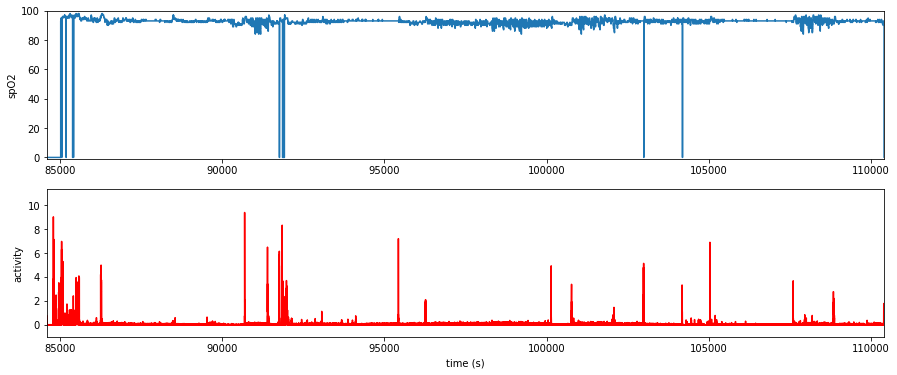

In [6]:
plt.figure()
plt.figure(figsize=(15,6))
plt.title('Plot spO2')
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
#plt.subplot(2, 1, 1)
plt.xlabel('time (s)')
ax1.set_ylabel('spO2')
ax1.axis([time_array[0],time_array[len(time_array)-1],-1,100])
ax1.step(time_array,spo2_array)
ax2.set_ylabel('activity')
ax2.axis([time_array[0],time_array[len(time_array)-1],-1,max(activity_array)+2])
ax2.step(time_activity_array,activity_array,c='r')

### Preprocessing spO2

In [7]:
#Outlier noise
str(datetime.timedelta(seconds=time_array[len(time_array)-1]))
index=df_spo2[df_spo2.spO2 == 0].index
#str(datetime.timedelta(seconds=time_array[58759]))
df_spo2=df_spo2.drop(df_spo2.index[index])  
df_outlier=pd.DataFrame()
df_outlier['time']=np.array(df_spo2['time'])
df_outlier['spO2']=np.array(df_spo2['spO2'])

Text(0.5,0,'time(s)')

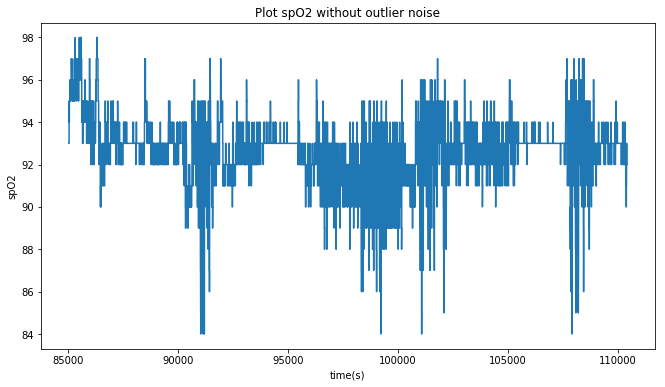

In [8]:
plt.figure(figsize=(11,6))
plt.title('Plot spO2 without outlier noise')
time_array=df_outlier['time']
spo2_array=df_outlier['spO2']
plt.step(time_array,spo2_array)
plt.ylabel('spO2')
plt.xlabel('time(s)')

### Detect activity using time series

In [9]:
serie=pd.DataFrame()
serie['activity']=activity_array
serie.index=df_activity['time']
ts = df_activity['activity'] 

media:  0.04216227188301306
std:  0.15763780659781457


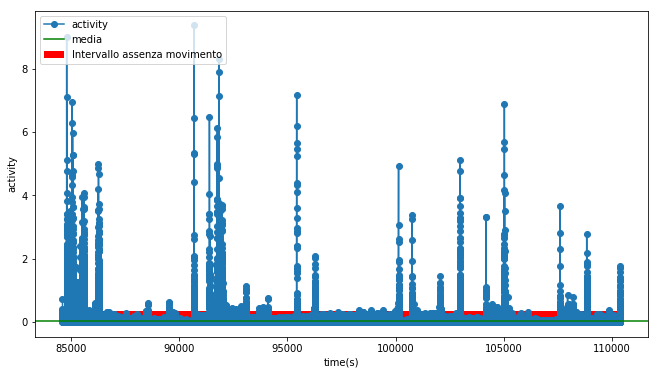

In [10]:
media=statistics.mean(activity_array)
std_dev=statistics.stdev(activity_array)
print('media: ',media)
print('std: ',std_dev)
def confidence_interval(alist, v, itv):
    return stats.t.interval(itv, df=len(alist)-1, loc=v, scale=stats.sem(alist))
CI=confidence_interval(activity_array, np.mean(activity_array), 0.1)

plt.figure(figsize=(11,6))
plt.xlabel('time(s)')
plt.ylabel('activity')
plt.plot(time_activity_array,activity_array,marker='o')
plt.axhline(y=media,color='green', linestyle='-',label='media')
plt.fill_between([time_activity_array[0],time_activity_array[len(time_activity_array)-1]],2*std_dev+media,0,facecolor='red', label='Intervallo assenza movimento')
plt.legend(loc='upper left')

Text(0,0.5,'activity')

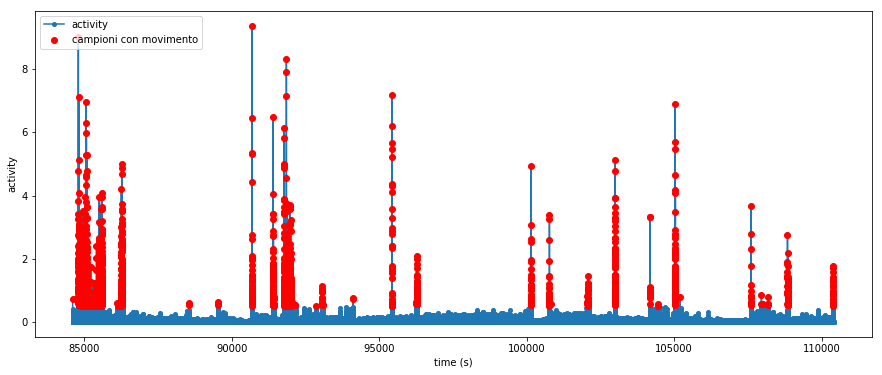

In [11]:

outlier=[]
durata=[]
valore=[]
attivita=[]
for i in range(0, len(activity_array)):
    if(activity_array[i]>3*std_dev+media):  
        outlier.append(time_activity_array[i])
        valore.append(activity_array[i])
        attivita.append(True)
    else:
        attivita.append(False)
plt.figure(figsize=(15,6))
#for i in range(0,len(outlier)):
plt.scatter(outlier,valore,marker='o', color="red",zorder=3,label='campioni con movimento')
plt.plot(time_activity_array,activity_array,marker='o',markersize=4,zorder=2, label='activity')
plt.legend(loc='upper left')
plt.xlabel('time (s)')
plt.ylabel('activity')

#### Creo un dizionario contenente ogni campione e se è presente attività

In [12]:
outlier = np.array(list(set(outlier)))
key=[i for i in time_array]
key=set(key)
values=[]
for i in (key):
    if(i in outlier):
        values.append(True)
    else:
        values.append(False)
diz=dict(zip(key, np.array(values).T))


### Algoritmo per l'estrazione dei 4 punti per la desaturazione

In [13]:
desaturations=pd.DataFrame()
spo2Translaction=[]
pstart=[]
pvalley1=[]
pvalley2=[]
pstop=[]
spo2_start=[]
spo2_stop=[]
spo2_start_s=[]
spo2_stop_s=[]
spo2_valley1=[]
spo2_valley2=[]
plowest=[]
ptraslaction=[]
tdown=[]
tup=[]
tlast=[]
durata=[]
attivita=[]
pv1=0
pv2=0
tup=[]
somma=0
pendenzaDiscesa=[]
pendenzaSalita=[]
'''somma=0
start_index=[]
stop_index=[]
pv1_index=[]
pv2_index=[]
stop=0'''
for i in range(0,len(spo2_array)):
    somma=somma+spo2_array[i]
xbase=1/len(spo2_array)*somma-10
CASE=0
discesa=False
minimo=100

for i in range(0,len(spo2_array)-2):
    if(CASE==0 and spo2_array[i]>spo2_array[i+1]):
        start_index=i
        minimo=100
        CASE=1
      #  minimo=spo2_array[i+1]
        discesa=True
    if(CASE==1 and spo2_array[i]==spo2_array[i+1]):
        if(discesa==True and spo2_array[i]<minimo):
            pv1=i
            minimo=spo2_array[i]
        discesa=False
    if(CASE==1 and spo2_array[i]>spo2_array[i+1]):
       # pv1=i
        pv2=i
      #  minimo=spo2_array[i+1]
        discesa=True
    if(CASE==1 and spo2_array[i]<spo2_array[i+1]):
        CASE=3
    if(CASE==3 and spo2_array[i]<spo2_array[i+1]):
        pv2=i
        #minimo=df_outlier['spO2'][i]
        CASE=4
    if(CASE==4 and spo2_array[i]==spo2_array[i+1] and spo2_array[i-1]<spo2_array[i]):
        stop_index=i
    if(CASE==4 and spo2_array[i]>spo2_array[i+1]):     
        true=0
          #stop_index=i     
        t_up=df_outlier['time'][stop_index]-df_outlier['time'][pv2]
        for k in range(start_index, pv2):
            if(true==0 and diz[df_outlier['time'][k]]==True):
                true=1
                stop_index=k
                translactionIndex=k
                pv2=k
                pv1=k
            if(true==0):
                translactionIndex=i
        #percentualeAttivita=true/d
        #if(percentualeAttivita>0):
          #  attivita.append(True)
        #else:
          #  attivita.append(False)
        
        start_time=df_outlier['time'][start_index]
        valley1_time=df_outlier['time'][pv1]
        valley2_time=df_outlier['time'][pv2]
        stop_time=df_outlier['time'][stop_index]
        spo2Stop=df_outlier['spO2'][stop_index]
        spo2Start=df_outlier['spO2'][start_index]
        d=df_outlier['time'][pv2]-start_time
        
        tdown=valley2_time-start_time
        if(df_outlier['spO2'][pv2]<=spo2Start*0.97 and df_outlier['spO2'][pv1]<=93 ):
            true=0
            
            ptraslaction.append(df_outlier['time'][translactionIndex])
            spo2Translaction.append(spo2_array[translactionIndex])
            spo2_start_s.append(datetime.timedelta(seconds=remove_days(start_time)))
            spo2_stop_s.append(datetime.timedelta(seconds=remove_days(stop_time)))          
            pstart.append(start_time)
            pstop.append(stop_time)
            spo2_start.append(spo2Start)
            spo2_stop.append(spo2Stop)
            spo2_valley1.append(df_outlier['spO2'][pv1])
            spo2_valley2.append(df_outlier['spO2'][pv2])
            pvalley1.append(valley1_time)
            pvalley2.append(valley2_time)
            durata.append(d)
            tup.append(spo2Stop-df_outlier['spO2'][pv2])
            pendenzaDiscesa.append((spo2Start-df_outlier['spO2'][pv1])/(valley1_time-start_time)*100)
            pendenzaSalita.append((spo2Stop-df_outlier['spO2'][pv2])/(stop_time-valley2_time)*100)
           # start_time=remove_days(start_time)
          #  stop_time=remove_days(stop_time)
          #  valley1_time=remove_days(valley1_time)
        start_index=i
        minimo=100
        CASE=1

            
desaturations['start_time']=pstart[0:len(pstart)]
desaturations['tup']=tup  
desaturations['valley1']=pvalley1  
desaturations['valley2']=pvalley2  
desaturations['stop_time']=pstop
desaturations['translaction']=ptraslaction 
desaturations['start_time_s']=spo2_start_s[0:len(pstart)]
desaturations['stop_time_s']=spo2_stop_s
desaturations['valley1_spO2']=spo2_valley1  
desaturations['valley2_spO2']=spo2_valley2  
desaturations['start_spO2']=spo2_start[0:len(pstart)]
desaturations['stop_spO2']=spo2_stop  
desaturations['spo2Translaction']=spo2Translaction  

desaturations['durata (s)']=durata   
desaturations['pendenzaDiscesa']=pendenzaDiscesa 
desaturations['pendenzaSalita']=pendenzaSalita 
#desaturations['attivita']=attivita 
#desaturations

In [14]:
#a=desaturations.loc[desaturations['attivita'] == False]
#a=desaturations.loc[desaturations['start_time'] > 86820]
a=desaturations
a[180:190]

,start_time,tup,valley1,valley2,stop_time,translaction,start_time_s,stop_time_s,valley1_spO2,valley2_spO2,start_spO2,stop_spO2,spo2Translaction,durata (s),pendenzaDiscesa,pendenzaSalita
180,108001.635654,5,108023.635938,108025.969302,108038.302795,108038.969470,06:00:01.635654,06:00:38.302795,90,90,97,95,95,24.333648,31.817771,40.540017
181,108038.969470,11,108079.303324,108083.636714,108098.303570,108099.303583,06:00:38.969470,06:01:38.303570,85,85,95,96,96,44.667244,24.793068,74.999031
182,108099.303583,7,108130.970659,108140.304112,108151.637592,108159.637696,06:01:39.303583,06:02:31.637592,88,88,96,95,95,41.000530,25.262831,61.763908
183,108159.637696,12,108185.971369,108194.971485,108218.305120,108231.305288,06:02:39.637696,06:03:38.305120,85,85,95,97,97,35.333790,37.974193,51.427907
184,108231.305288,4,108261.639013,108266.305740,108276.305870,108276.972545,06:03:51.305288,06:04:36.305870,92,92,97,96,96,35.000452,16.483304,39.999483
185,108276.972545,5,108296.639466,108299.972842,108324.306490,108336.306645,06:04:36.972545,06:05:24.306490,91,91,96,96,96,23.000297,25.423400,20.547680
186,108336.306645,7,108364.640344,108371.307097,108383.307252,108394.974069,06:05:36.306645,06:06:23.307252,90,90,96,97,97,35.000452,21.176197,58.332580
187,108394.974069,11,108434.307911,108435.307924,108449.974780,108453.308156,06:06:34.974069,06:07:29.974780,86,86,97,97,97,40.333854,27.965740,74.999031
188,108453.308156,5,108498.308738,108502.642127,108510.308893,108520.642360,06:07:33.308156,06:08:30.308893,90,90,97,95,95,49.333971,15.555355,65.216549
189,108520.642360,4,108534.975878,108539.975943,108564.642928,108573.976382,06:08:40.642360,06:09:24.642928,91,91,95,95,95,19.333583,27.906616,16.216007


### Grafico con le desaturazioni

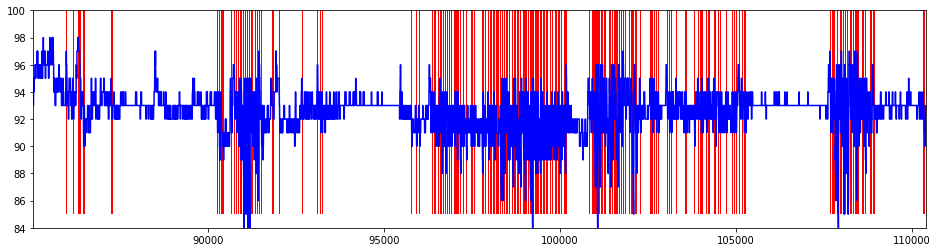

In [15]:
plt.figure(figsize=(16,4))
#plt.subplot(2, 1, 1)
plt.axis([time_array[0],time_array[len(time_array)-1],84,100])
for i in (a.index):
    plt.fill_between([a['start_time'][i],a['valley2'][i]],85,100,facecolor='red', zorder=1)
plt.plot(time_array,spo2_array,color='blue',zorder=2)


0 days 06:06:34.974069 , 97


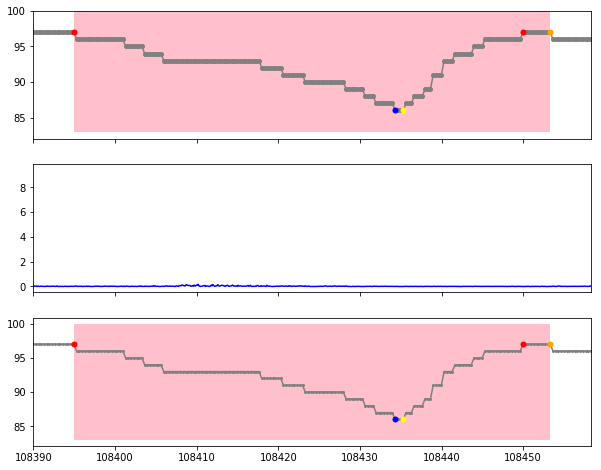

In [16]:
i=187
print(a['start_time_s'][i],',',a['start_spO2'][i])
f, axarr = plt.subplots(3, sharex=True,figsize=(10,8))
time_array=df_outlier['time']
spo2_array=df_outlier['spO2']
axarr[0].axis([pstart[i]-5,ptraslaction[i]+5,82,100])
axarr[0].plot(time_array,spo2_array, marker='o',markersize=4, color="gray")
#for i in range(0,len(desaturations)):
axarr[0].plot(pstart[i],spo2_start[i],  marker='o', markersize=5, color="red")
axarr[0].plot(pvalley2[i],spo2_valley2[i],  marker='o', markersize=5, color="yellow")
axarr[0].plot(pvalley1[i],spo2_valley1[i],  marker='o', markersize=5, color="blue")
axarr[0].plot(pstop[i],spo2_stop[i],  marker='o', markersize=5, color="red")
axarr[0].plot(ptraslaction[i],spo2Translaction[i],  marker='o', markersize=5, color="orange")
axarr[0].fill_between([pstart[i],ptraslaction[i]],spo2_start[i]+3,spo2_valley2[i]-3,facecolor='pink')

#ax2.fill_between([a['start_time'][i],a['stop_time'][i]],85,100,facecolor='red', zorder=1)
axarr[1].plot(outlier[i],valore[i],marker='o',markersize=3, color="red",zorder=3)
axarr[1].plot(time_activity_array,activity_array,color='blue',zorder=2)

axarr[2].plot(time_array,spo2_array, marker='o',markersize=2, color="gray")
if i in a.index:
    axarr[2].plot(a['start_time'][i],a['start_spO2'][i],marker='o', markersize=5, color="red")
    axarr[2].plot(a['stop_time'][i],a['stop_spO2'][i],marker='o', markersize=5, color="red")
    axarr[2].plot(a['valley1'][i],a['valley1_spO2'][i],  marker='o', markersize=5, color="blue")
    axarr[2].plot(a['valley2'][i],a['valley2_spO2'][i],  marker='o', markersize=5, color="yellow")
    axarr[2].plot(a['translaction'][i],a['spo2Translaction'][i],  marker='o', markersize=5, color="orange")
    axarr[2].fill_between([a['start_time'][i],a['translaction'][i]],spo2_start[i]+3,spo2_valley2[i]-3,facecolor='pink')

In [17]:
time_array

0         85021.672089
1         85022.005426
2         85022.338764
3         85022.672102
4         85023.005439
5         85023.338777
6         85023.672115
7         85024.005452
8         85024.338790
9         85024.672128
10        85025.005465
11        85025.338803
12        85025.672140
13        85026.005478
14        85026.338816
15        85026.672153
16        85027.005491
17        85027.338829
18        85027.672166
19        85028.005504
20        85028.338842
21        85028.672179
22        85029.005517
23        85029.338855
24        85029.672192
25        85030.005530
26        85030.338867
27        85030.672205
28        85031.005543
29        85031.338880
             ...      
75896    110391.333196
75897    110391.666533
75898    110391.999871
75899    110392.333208
75900    110392.666546
75901    110392.999884
75902    110393.333221
75903    110393.666559
75904    110393.999897
75905    110394.333234
75906    110394.666572
75907    110394.999910
75908    11

#### Trasformo i tempi di inizio in hh:mm:ss in secondi in modo da confrontarli con le desaturazioni calcolate

In [18]:
inizio_s=[]
for i in range(0,len(desatPSD)):
    s=desatPSD['Inizio'][i]
    h,m,sec=s.split(':')
    x=int(h)*3600+int(m)*60+int(sec)
    if(int(h)<21):
        x=x+24*3600
    inizio_s.append(x)
desatPSD['inizio_s']=inizio_s
print(desatPSD)
#desaturations=desaturations.loc[desaturations['start_time'] > 86820]
#print(a[0:30])

       Inizio  Durata  startSpO2  stopSpO2  inizio_s
0    23:46:33   26.33         97        94     85593
1    23:52:47   29.00         97        93     85967
2    23:55:52   22.00         95        92     86152
3    23:59:36   14.67         95        92     86376
4    00:00:43   18.67         94        90     86443
5    00:01:21   12.33         93        90     86481
6    00:04:43   25.67         95        92     86683
7    00:06:40   12.33         95        92     86800
8    01:04:03   29.00         94        91     90243
9    01:05:07   40.56         94        89     90307
10   01:06:02   80.20         94        89     90362
11   01:10:34   46.75         95        91     90634
12   01:12:23   27.33         95        92     90743
13   01:13:22   14.67         94        91     90802
14   01:14:10   23.67         94        90     90850
15   01:14:53   28.00         95        89     90893
16   01:15:39   26.29         95        89     90939
17   01:16:29   33.27         93        84    

#### Elimino le desaturazioni trovate che non hanno un corrispondente verificato dal polisonnigrafo in modo da calcolare la precisione delle altre

In [19]:
a=desaturations
array_index=a.index
array_start_desat=np.array(a['start_time'])
k=0
j=0
l=len(desatPSD)
while(j<l):
    if(desatPSD['inizio_s'][j]>array_start_desat[k]+30):
        print('ELIMI:',desatPSD['Inizio'][j],',',a['start_time_s'][array_index[k]])
        a=a.drop([array_index[k]], axis='rows')
        array_start_desat=np.array(a['start_time'])    
        array_index=a.index
    if(desatPSD['inizio_s'][j]<array_start_desat[k]-30):
        print('ELIMI PSD:',desatPSD['Inizio'][j],',',a['start_time_s'][array_index[k]])
        desatPSD=desatPSD.drop(j, axis='rows')
        j=j+1
    elif(desatPSD['inizio_s'][j]>=array_start_desat[k]-30 and desatPSD['inizio_s'][j]<=array_start_desat[k]+30):
        print('OK:',desatPSD['Inizio'][j],',',a['start_time_s'][array_index[k]])
        k=k+1
        j=j+1

a[0:len(desatPSD)]

ELIMI PSD: 23:46:33 , 0 days 23:52:47.684311
OK: 23:52:47 , 0 days 23:52:47.684311
OK: 23:55:52 , 0 days 23:55:52.353364
ELIMI: 23:59:36 , 0 days 23:58:31.022080
ELIMI PSD: 23:59:36 , 0 days 00:00:43.690461
OK: 00:00:43 , 0 days 00:00:43.690461
OK: 00:01:21 , 0 days 00:01:21.357614
OK: 00:04:43 , 0 days 00:04:43.693562
OK: 00:06:40 , 0 days 00:06:40.695074
ELIMI: 01:04:03 , 0 days 00:14:05.034148
OK: 01:04:03 , 0 days 01:04:05.406246
OK: 01:05:07 , 0 days 01:05:09.073735
OK: 01:06:02 , 0 days 01:06:03.407770
OK: 01:10:34 , 0 days 01:10:34.744609
OK: 01:12:23 , 0 days 01:12:23.412680
OK: 01:13:22 , 0 days 01:13:22.746780
OK: 01:14:10 , 0 days 01:14:10.747400
OK: 01:14:53 , 0 days 01:14:54.081293
OK: 01:15:39 , 0 days 01:15:39.748550
OK: 01:16:29 , 0 days 01:16:29.749196
OK: 01:17:22 , 0 days 01:17:22.416543
OK: 01:18:13 , 0 days 01:18:14.083877
OK: 01:19:15 , 0 days 01:19:16.084678
OK: 01:20:14 , 0 days 01:20:15.085440
OK: 01:20:53 , 0 days 01:20:54.085944
OK: 01:21:29 , 0 days 01:21:29

,start_time,tup,valley1,valley2,stop_time,translaction,start_time_s,stop_time_s,valley1_spO2,valley2_spO2,start_spO2,stop_spO2,spo2Translaction,durata (s),pendenzaDiscesa,pendenzaSalita
0,85967.684311,1,85988.684582,85996.351348,85996.684686,86001.018075,23:52:47.684311,23:53:16.684686,93,93,97,94,94,28.667037,19.047373,299.996124
1,86152.353364,2,86170.686934,86174.020310,86189.687179,86203.687360,23:55:52.353364,23:56:29.687179,92,92,95,94,94,21.666947,16.363425,12.765793
3,86443.690461,3,86458.690655,86462.024031,86473.024173,86481.357614,00:00:43.690461,00:01:13.024173,90,90,94,93,93,18.333570,26.666322,27.272375
4,86481.357614,2,86488.691043,86493.357769,86500.691198,86518.691430,00:01:21.357614,00:01:40.691198,90,90,93,92,92,12.000155,40.908562,27.272375
5,86683.693562,2,86696.027055,86709.027223,86725.027429,86732.027520,00:04:43.693562,00:05:25.027429,92,92,95,94,94,25.333661,24.324010,12.499839
6,86800.695074,1,86811.695216,86812.695229,86813.028566,86861.029186,00:06:40.695074,00:06:53.028566,92,92,95,93,93,12.000155,27.272375,299.996124
8,90245.406246,3,90263.739816,90274.073283,90284.073412,90300.740294,01:04:05.406246,01:04:44.073412,91,91,94,94,94,28.667037,16.363425,29.999612
9,90309.073735,5,90325.073942,90349.074252,90362.407757,90363.407770,01:05:09.073735,01:06:02.407757,89,89,94,94,94,40.000517,31.249596,37.499516
10,90363.407770,2,90428.741948,90442.742128,90448.075531,90467.075776,01:06:03.407770,01:07:28.075531,89,89,94,91,91,79.334358,7.652962,37.499516
11,90634.744609,5,90666.745023,90681.411879,90712.078942,90743.412680,01:10:34.744609,01:11:52.078942,91,91,95,96,96,46.667270,12.499839,16.304137


In [20]:
len(a)


174

#### Plot del'inizio valore spO2 ad inizio delle desaturazioni

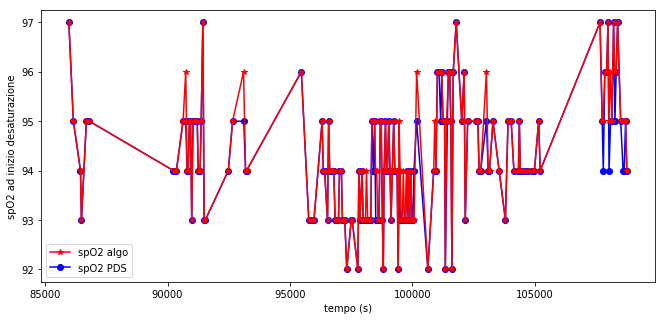

In [21]:
plt.figure(figsize=(11,5))
plt.plot(a['start_time'][0:len(desatPSD)],a['start_spO2'][0:len(desatPSD)],marker='*', color='red',zorder=2, label='spO2 algo')
plt.plot(desatPSD['inizio_s'],desatPSD['startSpO2'],marker='o',color='blue',zorder=1,label='spO2 PDS')
plt.ylabel('spO2 ad inizio desaturazione')
plt.xlabel('tempo (s)')
plt.legend(loc='best')

### Calcolo precisione algoritmo per il calcolo delle desaturazioni

##### Plot delle durate delle desat per ogni desat

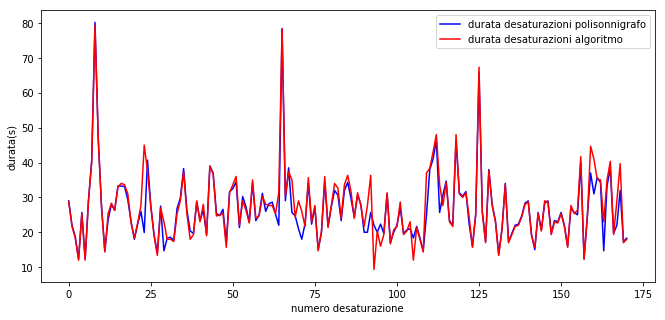

In [22]:
plt.figure(figsize=(11,5))
plt.plot([i for i in range (0,len(desatPSD))],desatPSD['Durata'],color='blue', label='durata desaturazioni polisonnigrafo')
plt.plot([i for i in range (0,len(desatPSD))],a['durata (s)'][0:len(desatPSD)],color='red', label='durata desaturazioni algoritmo')
plt.ylabel('durata(s)')
plt.xlabel('numero desaturazione')
plt.legend(loc='best')

In [23]:
desatPSD_index=desatPSD.index


##### Plot differenza tempo inizio delle desaturaz con quella precedente t(i+1)-t(i)

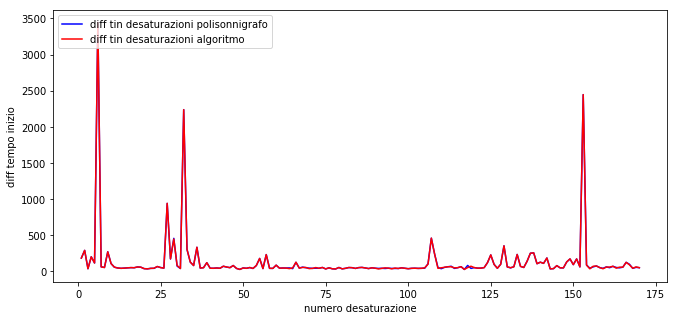

In [24]:
plt.figure(figsize=(11,5))
#plt.axis([0,3,50,60])
diff_tin_PDS=[]
diff_tin_algo=[]
for i in range(1,len(desatPSD_index)):
    diff_tin_PDS.append(desatPSD['inizio_s'][desatPSD_index[i]]-desatPSD['inizio_s'][desatPSD_index[i-1]])
    diff_tin_algo.append(a['start_time'][array_index[i]]-a['start_time'][array_index[i-1]])
plt.plot([i for i in range (1,len(desatPSD))],diff_tin_PDS,color='blue', label='diff tin desaturazioni polisonnigrafo')
plt.plot([i for i in range (1,len(desatPSD))],diff_tin_algo,color='red', label='diff tin desaturazioni algoritmo')
plt.ylabel('diff tempo inizio')
plt.xlabel('numero desaturazione')
plt.legend(loc='upper left')

##### Calcolo MSE per il tempo di inizio stimato e la durata

In [25]:
n=len(desatPSD)
#MSE tempo inizio
diff_tin=[]
for i in range(0,len(desatPSD_index)):
    diff_tin.append((a['start_time'][array_index[i]]-desatPSD['inizio_s'][desatPSD_index[i]])**2)
MSE_tempoInizio=1/n*sum(diff_tin)
print('MSE tempo di inizio delle desaturaz: ',MSE_tempoInizio, 's')

MSE tempo di inizio delle desaturaz:  11.470433618012247 s


In [26]:
#MSE durata
diff_durata=[]
for i in range(0,len(desatPSD_index)):
    diff_durata.append((a['durata (s)'][array_index[i]]-desatPSD['Durata'][desatPSD_index[i]])**2)
MSE_durata=1/n*sum(diff_durata)
print('MSE durata delle desaturaz: ',MSE_durata, 's')

MSE durata delle desaturaz:  12.245906219593058 s


In [27]:
for i in range (0,len(desatPSD_index)):
    print(i,',',a['start_time_s'][array_index[i]],',',desatPSD['Inizio'][desatPSD_index[i]],',',diff_tin[i])


0 , 0 days 23:52:47.684311 , 23:52:47 , 0.4682817730052333
1 , 0 days 23:55:52.353364 , 23:55:52 , 0.12486593175666276
2 , 0 days 00:00:43.690461 , 00:00:43 , 0.4767365542336912
3 , 0 days 00:01:21.357614 , 00:01:21 , 0.12788808734225127
4 , 0 days 00:04:43.693562 , 00:04:43 , 0.4810281539424707
5 , 0 days 00:06:40.695074 , 00:06:40 , 0.483127281338529
6 , 0 days 01:04:05.406246 , 01:04:03 , 5.790017688750312
7 , 0 days 01:05:09.073735 , 01:05:07 , 4.300376032304837
8 , 0 days 01:06:03.407770 , 01:06:02 , 1.9818167281786894
9 , 0 days 01:10:34.744609 , 01:10:34 , 0.5544427170067939
10 , 0 days 01:12:23.412680 , 01:12:23 , 0.17030457637782237
11 , 0 days 01:13:22.746780 , 01:13:22 , 0.5576798817959856
12 , 0 days 01:14:10.747400 , 01:14:10 , 0.5586065166475526
13 , 0 days 01:14:54.081293 , 01:14:53 , 1.1691946383499643
14 , 0 days 01:15:39.748550 , 01:15:39 , 0.5603266876413405
15 , 0 days 01:16:29.749196 , 01:16:29 , 0.5612942358442902
16 , 0 days 01:17:22.416543 , 01:17:22 , 0.1735079

In [28]:
for i in range (0,len(desatPSD_index)):
    print(i,':',desatPSD['Durata'][desatPSD_index[i]],' algo:',a['durata (s)'][array_index[i]])

0 : 29.0  algo: 28.66703704179963
1 : 22.0  algo: 21.66694660129724
2 : 18.67  algo: 18.333570201095426
3 : 12.33  algo: 12.000155040688696
4 : 25.67  algo: 25.333660641597817
5 : 12.33  algo: 12.000155040703248
6 : 29.0  algo: 28.667037041901494
7 : 40.56  algo: 40.00051680250908
8 : 80.2  algo: 79.33435832512623
9 : 46.75  algo: 46.667269603014574
10 : 27.33  algo: 27.000348841727828
11 : 14.67  algo: 14.333518520899815
12 : 23.67  algo: 25.33366064161237
13 : 28.0  algo: 28.333699401802733
14 : 26.29  algo: 26.333673561603064
15 : 33.27  algo: 33.000426362108556
16 : 33.25  algo: 34.00043928209925
17 : 33.15  algo: 33.667101642116904
18 : 29.33  algo: 31.000400521996198
19 : 23.0  algo: 22.66695952140435
20 : 18.0  algo: 18.333570201211842
21 : 22.33  algo: 22.66695952140435
22 : 26.0  algo: 27.66702412169252
23 : 19.94  algo: 45.00058140288456
24 : 40.67  algo: 37.66715332239983
25 : 27.67  algo: 27.333686481797486
26 : 19.33  algo: 19.000245481191087
27 : 13.98  algo: 13.333505600

In [29]:
for i in range(0,len(diff_tin)):
    print(i,',',diff_tin[i])

0 , 0.4682817730052333
1 , 0.12486593175666276
2 , 0.4767365542336912
3 , 0.12788808734225127
4 , 0.4810281539424707
5 , 0.483127281338529
6 , 5.790017688750312
7 , 4.300376032304837
8 , 1.9818167281786894
9 , 0.5544427170067939
10 , 0.17030457637782237
11 , 0.5576798817959856
12 , 0.5586065166475526
13 , 1.1691946383499643
14 , 0.5603266876413405
15 , 0.5612942358442902
16 , 0.17350794538759914
17 , 1.1747894653474973
18 , 1.1765265732326724
19 , 1.1781808193961745
20 , 1.1792749419057933
21 , 0.1761767189874544
22 , 0.06070586990158521
23 , 2.0188378841548746
24 , 11.708370564642651
25 , 0.5711718448927857
26 , 1.1874266526704071
27 , 4.417822947241041
28 , 4.427223984257549
29 , 67.62517100985954
30 , 1.234226579903274
31 , 1.2354038591099785
32 , 0.22441731856778063
33 , 4.598206688055308
34 , 4.605357368089424
35 , 3.289621749459955
36 , 6.173843540550045
37 , 7.944883137119008
38 , 0.2361845218848712
39 , 1.3322395030948233
40 , 0.6748138835711146
41 , 0.23882906265518855
42 , 0.

In [30]:
xbase=sum(spo2_array)/len(spo2_array)
xbase

92.62668914469351